# Classify different data sets

### Basic includes

In [0]:
# Using pandas to load the csv file
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from keras import models 
from keras import layers 
from keras import callbacks
from keras import optimizers
from keras.utils import to_categorical

# reuters and fashin mnist data set from keras
from keras.datasets import reuters
from keras.datasets import fashion_mnist

# needed to preprocess text
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


### Classify the Fashion Mnist

---

(60000, 28, 28)


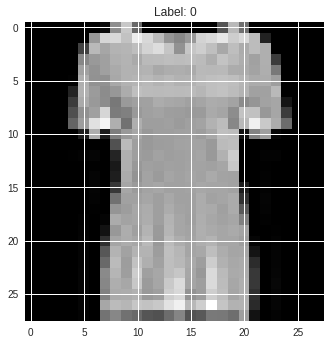

In [0]:
(fashion_train_data, fashion_train_labels), (fashion_test_data, fashion_test_labels) = fashion_mnist.load_data()

print(fashion_train_data.shape)

test_index = 10

plt.title("Label: " + str(fashion_train_labels[test_index]))
plt.imshow(fashion_train_data[test_index], cmap="gray")

#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

In [0]:
# Normalize the input data set

# flatten arrays
fashion_train_data = fashion_train_data.reshape((60000, 28 * 28))

# turn values from 0-255 to 0-1
fashion_train_data = fashion_train_data.astype('float32') / 255 

# same starndadization for the test images
fashion_test_data = fashion_test_data.reshape((10000, 28 * 28)) 
fashion_test_data = fashion_test_data.astype('float32') / 255

# one hot encoding
fashion_train_labels = to_categorical(fashion_train_labels) 
fashion_test_labels = to_categorical(fashion_test_labels)

# create 
validation_data = fashion_train_data[50000:]
validation_labels = fashion_train_labels[50000:]

# select the training set values
X = fashion_train_data[:50000]
y = fashion_train_labels[:50000]

#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [0]:
# use validation set

# The keras.models.Sequential class is a wrapper for the neural network model that treats 
# the network as a sequence of layers
network = models.Sequential()

# create network architecture
network.add(layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(64, activation='selu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(32, activation='selu'))
network.add(layers.Dropout(0.1))
network.add(layers.Dense(10, activation='softmax'))
network.summary()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=2)

# network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=20)
fit_network = network.fit(X, y, batch_size=1024, epochs=40, callbacks = [early_stop], validation_data=(validation_data, validation_labels))

evaluated_network = network.evaluate(fashion_test_data, fashion_test_labels)

print("Fit Network: ", fit_network)
print("Evaluated Network: ", evaluated_network)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


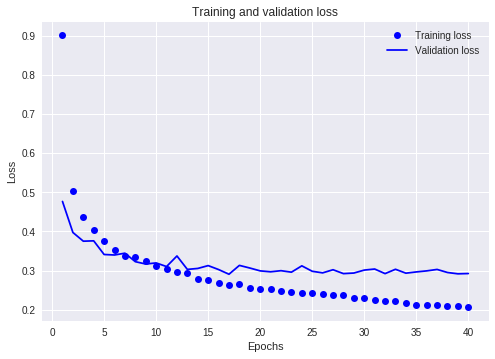

In [0]:
history_dict = fit_network.history
print(history_dict.keys())
# The history values are split in different lists for ease of plotting
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot of the validation and training loss

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Overfitting if: training loss << validation loss

# Underfitting if: training loss >> validation loss

# Just right if training loss ~ validation loss

## Classifying newswires

---

Build a network to classify Reuters newswires into 46 different mutually-exclusive topics.

### Load and review the data

In [0]:
words_count = 3700
(reuters_train_data, reuters_train_labels), (reuters_test_data, reuters_test_labels) = reuters.load_data(num_words=words_count)

print(reuters_train_data.shape)
print(reuters_train_labels.shape)
print(reuters_train_data[0])
print(reuters_train_labels[0])

print(set(reuters_train_labels))

2113536/2110848 [==============================] - 0s 0us/step
(8982,)
(8982,)
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


Load the word index to decode the train data.

In [0]:
word_index = reuters.get_word_index()

reverse_index = dict([(value+3, key) for (key, value) in word_index.items()])

reverse_index[0] = "<PAD>"
reverse_index[1] = "<START>"
reverse_index[2] = "<UNKNOWN>"  # unknown
reverse_index[3] = "<UNUSED>"

decoded_review = ' '.join([reverse_index.get(i,'?') for i in reuters_train_data[0]])

print(decoded_review)

<START> <UNKNOWN> <UNKNOWN> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <UNKNOWN> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

In [0]:
# Turning the output into vector mode, each of length 5000
tokenizer = Tokenizer(num_words=words_count)
reuters_train_data_token = tokenizer.sequences_to_matrix(reuters_train_data, mode='binary')
reuters_test_data_token = tokenizer.sequences_to_matrix(reuters_test_data, mode='binary')

print(reuters_train_data_token.shape)
print(reuters_test_data_token.shape)

# One-hot encoding the output
reuters_one_hot_train_labels = to_categorical(reuters_train_labels)
reuters_one_hot_test_labels = to_categorical(reuters_test_labels)
print(reuters_one_hot_train_labels.shape)
print(reuters_one_hot_test_labels.shape)

# Creating a validation set with the first 10000 reviews
reuters_validation_data = reuters_train_data_token[:2000]
reuters_validation_labels = reuters_one_hot_train_labels[:2000]

# Creating the input set
X = reuters_train_data_token[2000:]
y = reuters_one_hot_train_labels[2000:]
print(X.shape)
print(y.shape)

(8982, 3700)
(2246, 3700)
(8982, 46)
(2246, 46)
(6982, 3700)
(6982, 46)


#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [0]:
# use validation set

# The keras.models.Sequential class is a wrapper for the neural network model that treats 
# the network as a sequence of layers
network = models.Sequential()

# create network architecture
network.add(layers.Dense(128, activation='relu', input_shape=(words_count,)))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(46, activation='softmax'))
network.summary()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=20)

# network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

adagrad = optimizers.Adagrad(lr=0.0074, epsilon=None, decay=0.0065)
network.compile(optimizer=adagrad, loss='categorical_crossentropy', metrics=['accuracy'])

fit_network = network.fit(X, y, batch_size=256, epochs=40,
          callbacks=[early_stop], validation_data=(reuters_validation_data, reuters_validation_labels))
evaluated_network = network.evaluate(reuters_test_data_token, reuters_one_hot_test_labels)

print("Fit Network: ", fit_network)
print("Evaluated Network: ", evaluated_network)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               473728    
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 46)                2990      
Total params: 484,974
Trainable params: 484,974
Non-trainable params: 0
_________________________________________________________________
Train on 6982 samples, validate on 2000 samples
Epoch 1/40
6982/6982 [==============================] - 1s 180us/step - loss: 1.6831 - acc: 0.6405 - val_loss: 1.2862 - val_acc: 0.7280
Epoch 2/40
6982/6982 [==============================] - 1s 95us/step - loss: 0.8867 - acc: 0.8072 - val_loss: 1.0919 - val_acc: 0.7580
Epoch 3/40
6982/6982 [==============================] - 1s 97us/step - loss: 0.67

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


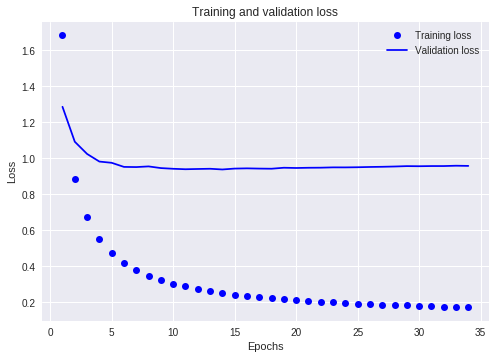

In [0]:
history_dict = fit_network.history
print(history_dict.keys())
# The history values are split in different lists for ease of plotting
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot of the validation and training loss

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Overfitting if: training loss << validation loss

# Underfitting if: training loss >> validation loss

# Just right if training loss ~ validation loss

## Predicting Student Admissions

---

Predict student admissions based on three pieces of data:

- GRE Scores
- GPA Scores
- Class rank

### Load and visualize the data

In [0]:
student_data = pd.read_csv("./student_data.csv")
print(student_data)

     admit    gre   gpa  rank
0        0  380.0  3.61   3.0
1        1  660.0  3.67   3.0
2        1  800.0  4.00   1.0
3        1  640.0  3.19   4.0
4        0  520.0  2.93   4.0
5        1  760.0  3.00   2.0
6        1  560.0  2.98   1.0
7        0  400.0  3.08   2.0
8        1  540.0  3.39   3.0
9        0  700.0  3.92   2.0
10       0  800.0  4.00   4.0
11       0  440.0  3.22   1.0
12       1  760.0  4.00   1.0
13       0  700.0  3.08   2.0
14       1  700.0  4.00   1.0
15       0  480.0  3.44   3.0
16       0  780.0  3.87   4.0
17       0  360.0  2.56   3.0
18       0  800.0  3.75   2.0
19       1  540.0  3.81   1.0
20       0  500.0  3.17   3.0
21       1  660.0  3.63   2.0
22       0  600.0  2.82   4.0
23       0  680.0  3.19   4.0
24       1  760.0  3.35   2.0
25       1  800.0  3.66   1.0
26       1  620.0  3.61   1.0
27       1  520.0  3.74   4.0
28       1  780.0  3.22   2.0
29       0  520.0  3.29   1.0
..     ...    ...   ...   ...
370      1  540.0  3.77   2.0
371      1

Plot of the GRE and the GPA from the data.

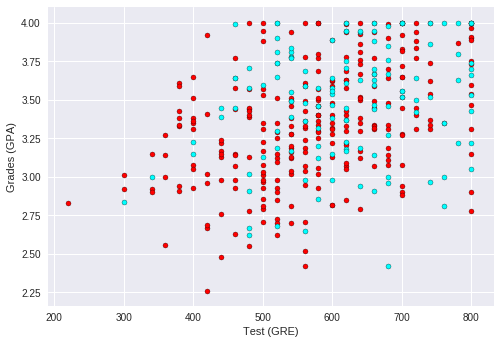

In [0]:
X = np.array(student_data[["gre","gpa"]])
y = np.array(student_data["admit"])
admitted = X[np.argwhere(y==1)]
rejected = X[np.argwhere(y==0)]
plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
plt.xlabel('Test (GRE)')
plt.ylabel('Grades (GPA)')

plt.show()

Plot of the data by class rank.

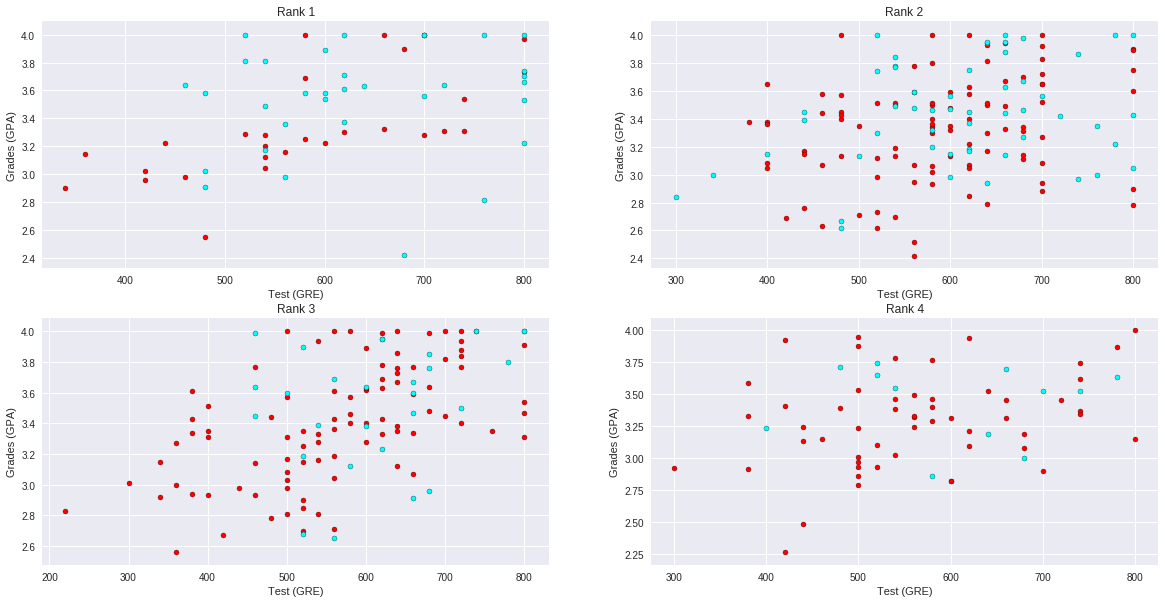

In [0]:
f, plots = plt.subplots(2, 2, figsize=(20,10))
plots = [plot for sublist in plots for plot in sublist]

for idx, plot in enumerate(plots):
    data_rank = student_data[student_data["rank"]==idx+1]
    plot.set_title("Rank " + str(idx+1))
    X = np.array(data_rank[["gre","gpa"]])
    y = np.array(data_rank["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plot.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plot.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plot.set_xlabel('Test (GRE)')
    plot.set_ylabel('Grades (GPA)')
    

#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

In [0]:
def standardize(vector):
  mean = np.mean(vector)
  sigma = np.std(vector)
  for i in range(0, vector.size):
    vector[i] = (int(vector[i]) - mean)/sigma
    

In [0]:
def cleanData(dataset):
  index = 0
  limit = dataset.shape[0]
  while(index < limit):
    flag = 0
    for j in range(0, dataset.shape[1]):
      if math.isnan(dataset[index][j]):
        flag = 1
    if flag:
      dataset = np.delete(dataset, index, axis=0)
      index = index - 1
      limit = limit - 1
    index = index + 1
  return dataset

In [0]:
# Normalize the input data set
# Creating array
student_data_array = np.array(student_data)
student_data_array[np.isnan(student_data_array)] = 0
np.random.shuffle(student_data_array)

# Get read of observations without data
# student_data_array_clean = cleanData(student_data_array)

# Get GRE and GPA vectors
X_gre = student_data_array[:,1]
X_gpa = student_data_array[:,2]

# Normalize the input data set
standardize(X_gre)
standardize(X_gpa)

# Perform one hot encoding
# Input
rank = student_data_array[:,3]
rank = rank-1
rank_encoded = to_categorical(rank)

# Output
y_admit = student_data_array[:,0]
y_admit_encoded = to_categorical(y_admit)

dataset = np.matrix([X_gre[:], X_gpa[:]]).T
dataset = np.concatenate((dataset, rank_encoded), axis=1)

observations = 200
# Training Set
X = dataset[:observations]
y = y_admit_encoded[:observations]

# Test set
student_test_data = dataset[observations:observations+100]
student_test_labels = y_admit_encoded[observations:observations+100]

# Validation set
student_validation_data = dataset[observations+100:]
student_validation_labels = y_admit_encoded[observations+100:]








#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [83]:
# use validation set

# The keras.models.Sequential class is a wrapper for the neural network model that treats 
# the network as a sequence of layers
network = models.Sequential()

# create network architecture
network.add(layers.Dense(128, activation='relu', input_shape=(6,)))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(2, activation='softmax'))
network.summary()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=20)

# network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

adagrad = optimizers.Adagrad(lr=0.0074, epsilon=None, decay=0.0065)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
network.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=['accuracy'])

fit_network = network.fit(X, y, batch_size=256, epochs=40,
          callbacks=[early_stop], validation_data=(student_validation_data, student_validation_labels))
evaluated_network = network.evaluate(student_test_data, student_test_labels)

print("Fit Network: ", fit_network)
print("Evaluated Network: ", evaluated_network)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 66        
Total params: 11,298
Trainable params: 11,298
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 100 samples
Epoch 1/40
200/200 [==============================] - 1s 6ms/step - loss: 0.6845 - acc: 0.6000 - val_loss: 0.6505 - val_acc: 0.7000
Epoch 2/40
200/200 [==============================] - 0s 46us/step - loss: 0.6687 - acc: 0.6

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


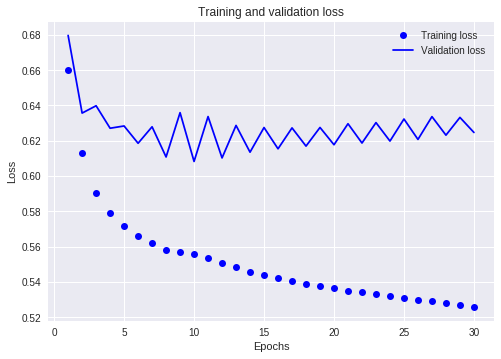

In [64]:
history_dict = fit_network.history
print(history_dict.keys())
# The history values are split in different lists for ease of plotting
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot of the validation and training loss

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Overfitting if: training loss << validation loss

# Underfitting if: training loss >> validation loss

# Just right if training loss ~ validation loss